In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import numpy as np
import math, random,datetime,os
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
# ---------------------------- PARAMS  ------------------------------- #
EPOCHS = 1
LEARNING_RATE = 0.1
HIDDEN_DIMS = 25
NUM_LSTM_CELLS = 1
NUM_WINDOWS = 5
WINDOW_LENGTH = 8760 #1-year windows
FORECAST_HORIZON = 1
MODEL_PATH = '.\models\model_423_1652_24hr_1000_epoch.pkl'

In [3]:
# ------------------------ Define Network  --------------------------- #
class LSTM(torch.nn.Module):
    def __init__(self, input_dimensions, hidden_dimensions, num_lstm_cells=1, lstm_dropout=0.1):
        super(LSTM, self).__init__()

        # Parameters
        self.input_dim = input_dimensions
        self.hidden_dim = hidden_dimensions
        self.num_lstm_cells = num_lstm_cells
        self.lstm_dropout = lstm_dropout

        # Network layers
        self.lstm = nn.LSTM(input_dimensions, hidden_dimensions, dropout=0.1, num_layers=num_lstm_cells)
        self.c1 = nn.Linear(hidden_dimensions, hidden_dimensions)
        self.out = nn.Linear(hidden_dimensions, 1, bias=False)

    def forward(self, x):
        h_1, c_1 = self.lstm(x)
        output = self.c1(h_1.squeeze(1))
        output = self.out(output)
        return output



In [4]:
# ---------------------- Load and Process Data  ---------------------- #
data = pd.read_csv('full_data.csv', index_col=0)
cols = ['apparentTemperature', 'humidity','MWh']
df = data[cols]

df = (df - df.min())/(df.max()-df.min()) ##Min-Max Normalization
#df = (df - df.mean())/df.std() ##Gaussian normalization

inputs = df
targets = df['MWh'] #Un-normalized targets

#Percentage of samples to use as training data
TRAINING_SAMPLE_RATIO = 0.7
num_training_samples = round(len(inputs)*TRAINING_SAMPLE_RATIO)

#Splits data samples 
(training_inputs,test_inputs) = np.split(inputs.values,[num_training_samples])
(training_targets,test_targets) = np.split(targets.values,[num_training_samples])

#Splits timestamps for plotting later
(training_t,test_t) = np.split(data['index'].values,[num_training_samples])

#Prepares training data for input to network
training_inputs = Variable(torch.from_numpy(training_inputs).float())#.cuda()
training_targets = Variable(torch.from_numpy(training_targets).float())#.cuda()
test_inputs = Variable(torch.from_numpy(test_inputs).float())#.cuda()
test_targets = Variable(torch.from_numpy(test_targets).float())#.cuda()


In [5]:
# -------------------- Instantiate LSTM Network  --------------------- #
# Model Params
input_dim = training_inputs.shape[1]
hidden_dim = HIDDEN_DIMS

# Create model and necessary functions
model = LSTM(input_dim, HIDDEN_DIMS, num_lstm_cells=NUM_LSTM_CELLS)#.cuda()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)



In [6]:

def test_model():
    #Apply test data
    index = round(random.random()*(len(test_inputs)-WINDOW_LENGTH-FORECAST_HORIZON)) #Selects a random index from test data

    t = test_t[index+FORECAST_HORIZON:index+WINDOW_LENGTH+FORECAST_HORIZON] #timestamps for plotting
    t = matplotlib.dates.datestr2num(t)
    
    window = test_inputs[index:index+WINDOW_LENGTH].unsqueeze(1)
    target = test_targets[index+FORECAST_HORIZON:index+WINDOW_LENGTH+FORECAST_HORIZON]
    output = model(window)
    
    return output,target,t

In [7]:
def plot_outputs(output,target,t,frame,imgname):#De-normalize outputs and targets for plotting
    op = output.squeeze(1).data.numpy()
    tg = target.data.numpy()
    mx = data['MWh'].max()
    mn = data['MWh'].min()
    op = op*(mx-mn) + mn
    tg = tg*(mx-mn) + mn
    frame = -1*frame
    
    x = matplotlib.dates.num2date(t[frame:])
    y1 = op[frame:]
    y2 = tg[frame:]

    plt.plot(x,y1)
    plt.plot(x,y2)
    plt.xlabel('Date/Hour')
    plt.ylabel('Demand (MWh)')
    plt.title('Predictions')
    plt.xticks(rotation=45)
    plt.legend(('Predicted Demand','Actual'))
    plt.subplots_adjust(bottom = 0.22)
    plt.savefig(imgname,dpi=600)
    

In [8]:
def calculate_error(output,targets):#Calculate error after running one of the models.
#err = np.absolute(np.divide((tg.data.numpy()-op.squeeze(1).data.numpy()),tg.data.numpy()))
    o = output.squeeze(1).data.numpy()
    tar = targets.data.numpy()
    mx = data['MWh'].max()
    mn = data['MWh'].min()
    o = o*(mx-mn) + mn
    tar = tar*(mx-mn) + mn

    abse = (np.absolute(tar-o))/tar
    err = abse.mean()

    print(tg.data.numpy().shape)
    print(op.squeeze(1).data.numpy().shape)
    print(err.shape)
    print(err)

    mse = criterion(op,tg)
    print(mse.data[0])
    
    return err,mse

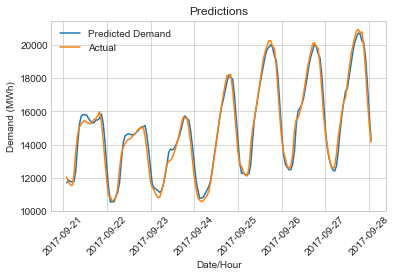

In [9]:
#Plot 1000 Epoch, Hour-Ahead Model
#model = torch.load(MODEL_PATH,map_location=lambda storage, loc: storage)
model.load_state_dict(torch.load('.\models\model_424_1637_state_dict.pkl', map_location=lambda storage,loc: storage))

#Generate plot for 24-hr ahead model
op,tg,t = test_model()
sns.set_style('whitegrid')
plot_outputs(op,tg,t,168,'1000Epoch_1Hr_Ahead')


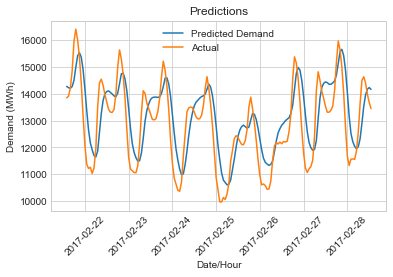

In [9]:
#Plot 100 Epoch, Hour-Ahead Model
#model = torch.load(MODEL_PATH,map_location=lambda storage, loc: storage)
model.load_state_dict(torch.load('.\models\model1hr100epoch_state_dict.pkl', map_location=lambda storage,loc: storage))

#Generate plot for 24-hr ahead model
op,tg,t = test_model()
sns.set_style('whitegrid')
plot_outputs(op,tg,t,168,'100Epoch_1hr_Ahead')

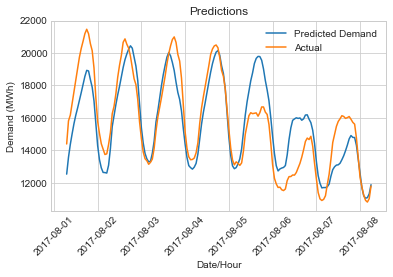

In [9]:
#Plot 24-Hour Ahead Model
#model = torch.load(MODEL_PATH,map_location=lambda storage, loc: storage)
FORECAST_HORIZON = 24
model.load_state_dict(torch.load('.\models\model_423_1652_state_dict.pkl', map_location=lambda storage,loc: storage))

#Generate plot for 24-hr ahead model
op,tg,t = test_model()
sns.set_style('whitegrid')
plot_outputs(op,tg,t,168,'1000Epoch24HrAhead')

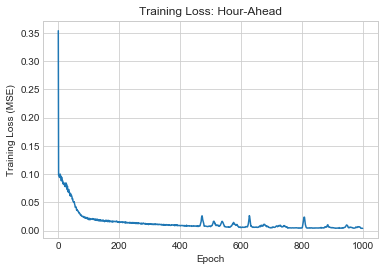

In [11]:
#Plot Losses for 1000 Epoch Model
losses = pd.read_csv('.\losses\loss_424_1637.csv')
plt.plot(losses['0'].values)
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss: Hour-Ahead')
plt.savefig('TrainingLossesHrAhead',dpi=600)

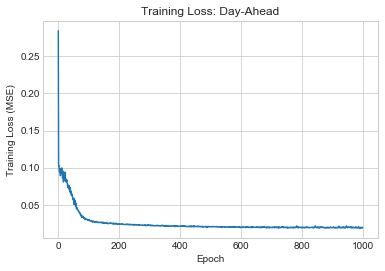

In [12]:
#Plot Losses for Day-Ahead Model
losses = pd.read_csv('.\losses\loss_423_1652.csv')
plt.plot(losses['0'].values)
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss: Day-Ahead')
plt.savefig('TrainingLossesDayAhead',dpi=600)

In [10]:
o = op.squeeze(1).data.numpy()
targ = tg.data.numpy()
csvoutput = np.array([o,targ])
np.savetxt('24hr_Ahead_Results.csv',np.transpose(csvoutput),delimiter=',')